In [1]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import utils

### In this notebook, we'll use 3 different scikit-learn techniques to make models for prediciting whether a loan will be approved or not

We use: Gradient Boosting, Random Forest, K-Nearest Neighbors

## EDA

We'll start by importing our dataset and taking a look at each of the columns and their structure

In [2]:
df = pd.read_csv("../Data/credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
#df["loan_intent"].value_counts()  uncomment this line to get the frequency of each value for the specified column    

Inspect our dataset for any missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


We see the columns "person_emp_length" and "loan_int_rate" both have null values that need to be addressed

Before filling NaNs, let's quickly separate the dataset into features and labels

In [5]:
data_features = pd.concat([df.iloc[:,:8], df.iloc[:,9:]], axis=1)         #All columns other than 8
data_labels = df.iloc[:, 8]                                               #Column 8

data_features.shape, data_labels.shape

((32581, 11), (32581,))

Now we'll replace the NaN values with the median of their column

In [6]:
nan_features = ["person_emp_length", "loan_int_rate"]
for col in nan_features:
    data_features[col] = data_features[col].fillna(data_features[col].median())

data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  object 
 10  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 2.7+ MB


Our dataset now contains no missing values

## Feature Encoding

Binary encode our columns that only have 2 unique values.

First is our label column

In [7]:
lb = LabelBinarizer()
bin_labels = lb.fit_transform(data_labels)

bin_labels.shape


(32581, 1)

Now binarize the "cb_person_default_on_file" column

In [8]:
data_features = utils.encode_feature(["cb_person_default_on_file"],
               LabelBinarizer(),
               data_features,
               Binary=True)

Next we'll use the ordinal encoder on our one column with a distinct order, "loan_grade"

In [9]:
ord_categories = ["G", "F", "E", "D", "C", "B", "A"]
oe = OrdinalEncoder(categories=[ord_categories])

data_features = utils.encode_feature(["loan_grade"],
                                        oe,
                                        data_features)

The categorical data will be encoded using the OneHotEncoder

In [11]:
###One-hot encode categorical data

ohe = OneHotEncoder(categories="auto", sparse_output=False)
categorical_features = ["person_home_ownership", "loan_intent"]

data_features = utils.encode_feature(categorical_features,
                               ohe,
                               data_features,
                               OneHot=True)


The rest of the columns in our dataset are already numerical, so we just neede to scale them

In [13]:
###Normalize numerical data

scaler = StandardScaler()
Num_data_list = ["person_income", "person_age", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]


data_features = utils.encode_feature(Num_data_list,
                        scaler,
                        data_features)

Our last step before beginning model training is to split the dataset into training and testing sets

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, test_size=0.2)

## K-neighbors

Let's start with simple KNN mode and check the accuracy over a range of k values to find the optimal k


In [17]:
Acc = 0
k = 0
for k in range(2,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    score = accuracy_score(y_test, preds)
    if score > Acc:
        Acc = score
        k_optimal = k


print(f'The optimal k value is: {k_optimal}, with a test accuracy of: {(Acc * 100):.3f}%')

The optimal k value is: 7, with a test accuracy of: 89.305%


Let's use our train_eval_model function at this optimal k value and vizualize the results

Training accuracy: 91.452
Test accuracy: 89.305


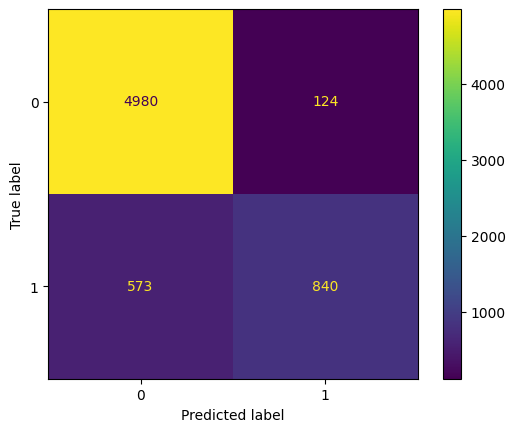

In [18]:
knn_opt = KNeighborsClassifier(n_neighbors=k_optimal)
utils.train_eval_model(knn_opt, X_train, y_train, X_test, y_test)

## Random Forest Classifier

Before using RandomForestClassifier, let's see how a single decision tree performs

Training accuracy: 100.000
Test accuracy: 89.489


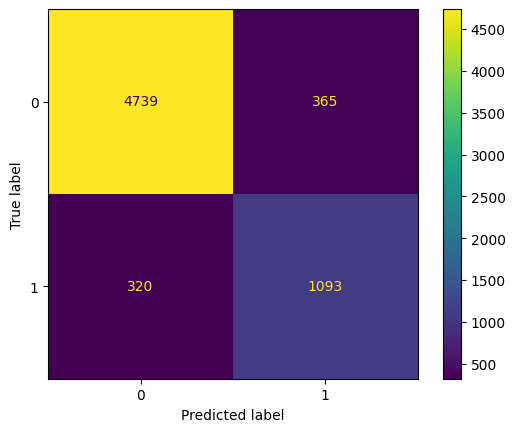

In [19]:
DT = DecisionTreeClassifier()

utils.train_eval_model(DT, X_train, y_train, X_test, y_test)

A single decision tree does very well at fitting the training data, but it doesn't generalize well

Now try the RandomForestClassifier

Use GridSearchCV to search for the parameters that correlate to the best test accuracy (start with a broad range of parameters and gradually narrow them)

In [20]:
RFC = RandomForestClassifier()

param_grid = {'n_estimators' : [30, 35, 40],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth' : [8, 9, 10, 11]
              }

In [21]:
Grid_RFC = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5)
Grid_RFC.fit(X_train, y_train)

print(f'Optimal parameters are determined to be: {Grid_RFC.best_params_}')

Optimal parameters are determined to be: {'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 35}


Now we use these parameters to train a model

Training accuracy: 93.646
Test accuracy: 93.095


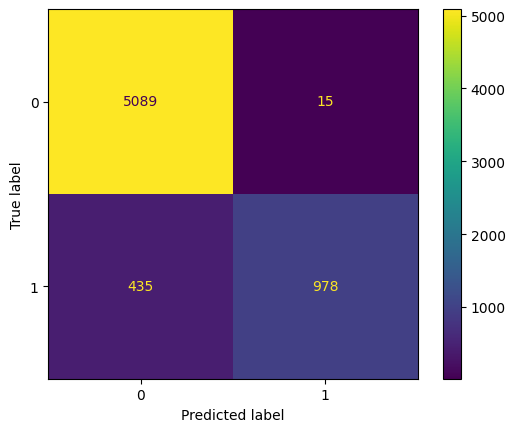

In [22]:
RFC_opt = RandomForestClassifier(criterion=list(Grid_RFC.best_params_.values())[0],
                                 max_depth=list(Grid_RFC.best_params_.values())[1],
                                 n_estimators=list(Grid_RFC.best_params_.values())[2])

utils.train_eval_model(RFC_opt, X_train, y_train, X_test, y_test, savefig=True)

We see the random forest has a lower training accuracy, but generalizes much better leading to a higher test accuracy

## Gradient Boosting

Last, we'll try a model that uses gradient boosting. Similar to the random forest, we can use GridSearchCV to find the optimal parameters

In [23]:
GBC = GradientBoostingClassifier()

param_grid = {"learning_rate" : [0.07, 0.08, 0.09],
              "n_estimators" : [195, 200, 205],
              "max_depth" : [5,6,7]}

In [24]:
Grid_GBC = GridSearchCV(estimator=GBC, param_grid=param_grid, cv=5)
Grid_GBC.fit(X_train, y_train)

print(f'Optimal parameters are determined to be: {Grid_GBC.best_params_}')

Optimal parameters are determined to be: {'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 200}


Again we define a model using these parameters

Training accuracy: 96.075
Test accuracy: 93.617


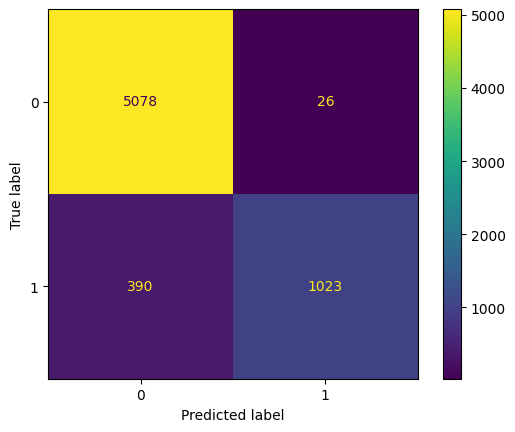

In [25]:
GBC_opt = GradientBoostingClassifier(learning_rate=list(Grid_GBC.best_params_.values())[0],
                                    max_depth=list(Grid_GBC.best_params_.values())[1],
                                    n_estimators=list(Grid_GBC.best_params_.values())[2])

utils.train_eval_model(GBC_opt, X_train, y_train, X_test, y_test, savefig=True)

### The test accuracy of our GradientBoostingClassifier model appears to be slightly but consistently higher than that of our RandomForestClassifier, and is significantly higher than that of the KNeighborsClassifier